In [50]:
import sys
sys.path.append("../") # 상위 폴더의 model.py를 import 하기 위해 path 추가
from model import make_model
import pandas as pd
from kobert.utils import get_tokenizer
from gluonnlp.data import SentencepieceTokenizer
import torch

In [51]:
num_decoder_layers = 3
model_path = '../output/step_30000.pth'

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, vocab = make_model(num_decoder_layers)
# model.load_state_dict(torch.load(model_path, map_location=device)['model'])
model.load_state_dict(dict([(n[len('module.'):], p) for n, p in torch.load(model_path, map_location=device)['model'].items()]), strict=True)
model.eval()
sp  = SentencepieceTokenizer(get_tokenizer())

using cached model
using cached model
using cached model


In [53]:
device

device(type='cuda', index=0)

In [73]:
question = '배가고프네요.'
max_len = 20

qtokens = sp(question)
qtokens = ['[CLS]'] + qtokens
token_ids = [vocab.token_to_idx[tok] for tok in qtokens]
# unsqueeze(0) for Batch position (zzingae)
token_ids = torch.tensor(token_ids).unsqueeze(0)
# attention score: [Batch, Head, tgt_length, src_length] in src_attn (zzingae)
# unsqueeze(1) for tgt_length position (zzingae)
attn_mask = (token_ids != vocab.token_to_idx['[PAD]'])
answer = model.greedy_decode(token_ids, attn_mask, max_len, vocab)

answer = answer[1][0,:].tolist()
answer = answer[:answer.index(vocab.token_to_idx['[SEP]'])]

In [74]:
with open('QnA_examples.txt','a',encoding='utf-8') as txt:
    Q = 'Q: '+''.join(qtokens[1:]).replace('▁',' ')
    A = 'A: '+''.join([vocab.idx_to_token[idx] for idx in answer[1:]]).replace('▁',' ')
    txt.write(Q+'\n'+A+'\n')
    print(Q)
    print(A)

Q:  배가고프네요.
A:  이제 그만 놓아주세요.


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


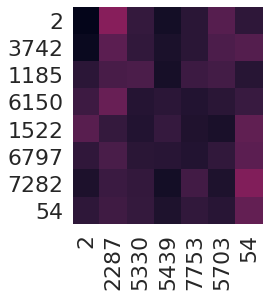

In [75]:
import matplotlib.pylab as plt
import seaborn

# for showing Korean in plot
plt.rcParams['font.family'] = 'NanumGothic'

def draw(data, x, y):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

last_layer = 2
# mean of attention weights from all heads (zzingae)
multi_heads_enc_dec_attention_weights = model.decoder.layers[last_layer].src_attn.attn.data
mean_attention = torch.mean(multi_heads_enc_dec_attention_weights, dim=[0,1])
mean_attention = mean_attention.cpu().detach().numpy()[:len(answer),:]

plt.figure()
draw(mean_attention, [vocab.token_to_idx[tok] for tok in qtokens], answer)
printQ = ''.join(qtokens[1:])
printA = ''.join([vocab.idx_to_token[idx] for idx in answer[1:]])
plt.savefig('{},{}.png'.format(printQ,printA))
plt.show()

In [65]:
vocab.idx_to_token[2011]

'▁먹고'

Decoder Src Layer 1
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


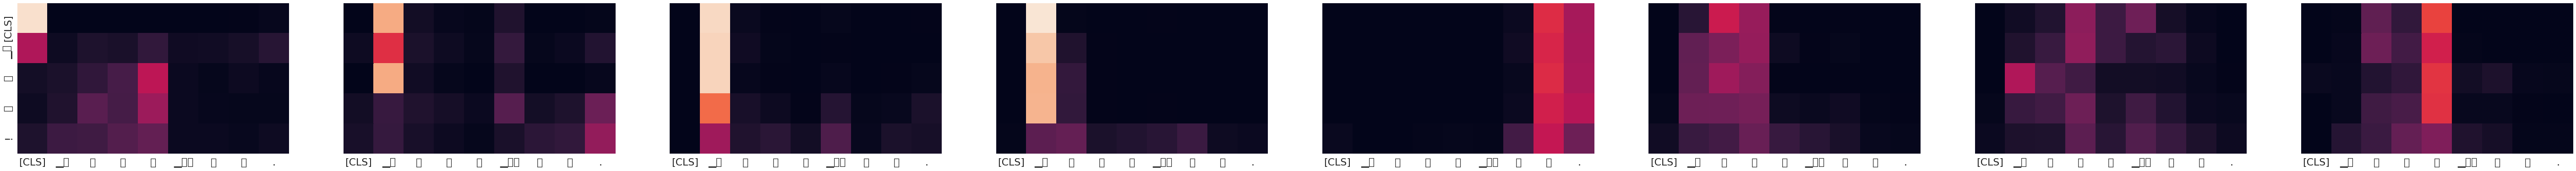

Decoder Src Layer 2


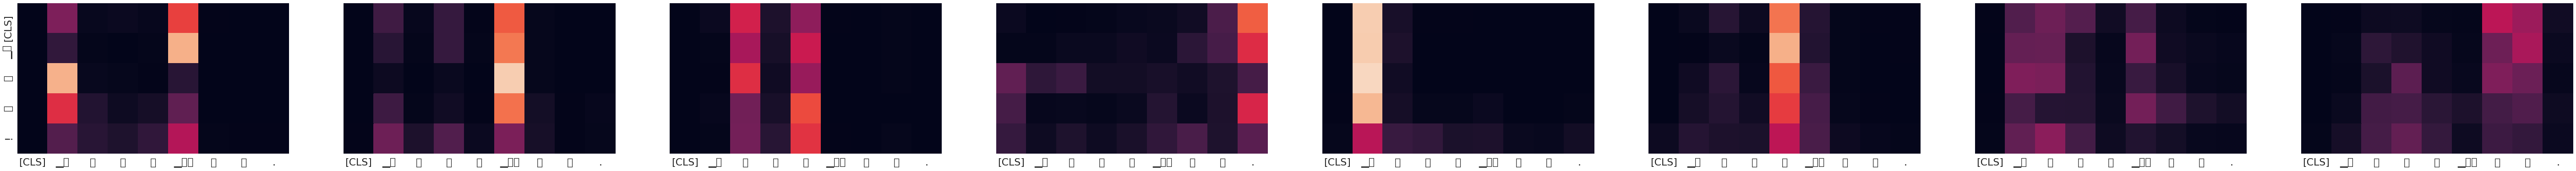

Decoder Src Layer 3


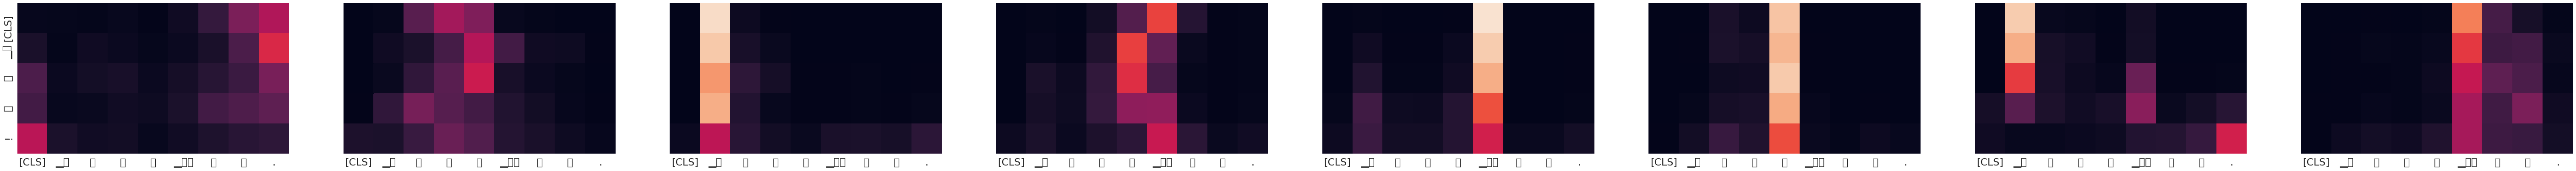

In [72]:
import matplotlib.pylab as plt
import seaborn as sns

# for showing Korean in plot
sns.set(font_scale=2)
plt.rcParams['font.family'] = 'AppleGothic'

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

last_layer = 3
heads=8
Q = qtokens
A = [vocab.idx_to_token[idx] for idx in answer]

    
# for layer in range(last_layer):
#     fig, axs = plt.subplots(1,heads, figsize=(20, 10))
#     print("Encoder Layer", layer+1)
#     for h in range(heads):
#         draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
#             Q, Q if h ==0 else [], ax=axs[h])
#     plt.show()
    
for layer in range(last_layer):
    # fig, axs = plt.subplots(1,heads, figsize=(20, 10))
    # print("Decoder Self Layer", layer+1)
    # for h in range(heads):
    #     draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(A), :len(A)], 
    #         A, A if h ==0 else [], ax=axs[h])
    # plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,heads, figsize=(100, 50))
    for h in range(heads):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(A), :len(Q)], 
            Q, A if h ==0 else [], ax=axs[h])
    plt.show()